In [1]:
import os
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

# Visualize eplusout.sql

In [2]:
# Connect to SQL
sql_path = 'eplusout.sql'
conn = sqlite3.connect(sql_path)

# Define Queries
def select_all_from_table(table_name):
    q = "SELECT * FROM {}".format(table_name)
    return pd.read_sql(q, conn)

def select_tabular_report(report_name, table_name=None):
    q = "SELECT * FROM TabularDataWithStrings WHERE ReportName='{}'".format(report_name)
    if table_name:
        q = q + " and TableName='{}'".format(table_name)
    return pd.read_sql(q, conn)

def select_tables():
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query ,conn)


In [3]:
# helper functions
def gj_to_kwh(gj):
    return gj * 277.8

def j_to_kwh(j):
    return j * 2.77778e-7

def get_total_floor_area():
    z = select_all_from_table('Zones')
    return z['FloorArea'].sum()

## SHOW TABLES

In [4]:
tables = select_tables()
tables.name.values

array(['Simulations', 'EnvironmentPeriods', 'Errors', 'Time', 'Zones',
       'ZoneLists', 'ZoneGroups', 'ZoneInfoZoneLists', 'Schedules',
       'Materials', 'Constructions', 'ConstructionLayers', 'Surfaces',
       'ReportDataDictionary', 'ReportData', 'ReportExtendedData',
       'NominalPeople', 'NominalLighting', 'NominalElectricEquipment',
       'NominalGasEquipment', 'NominalSteamEquipment',
       'NominalHotWaterEquipment', 'NominalOtherEquipment',
       'NominalBaseboardHeaters', 'NominalInfiltration',
       'NominalVentilation', 'ZoneSizes', 'SystemSizes', 'ComponentSizes',
       'RoomAirModels', 'DaylightMaps', 'DaylightMapHourlyReports',
       'DaylightMapHourlyData', 'StringTypes', 'Strings', 'TabularData'],
      dtype=object)

## PLOT END USES

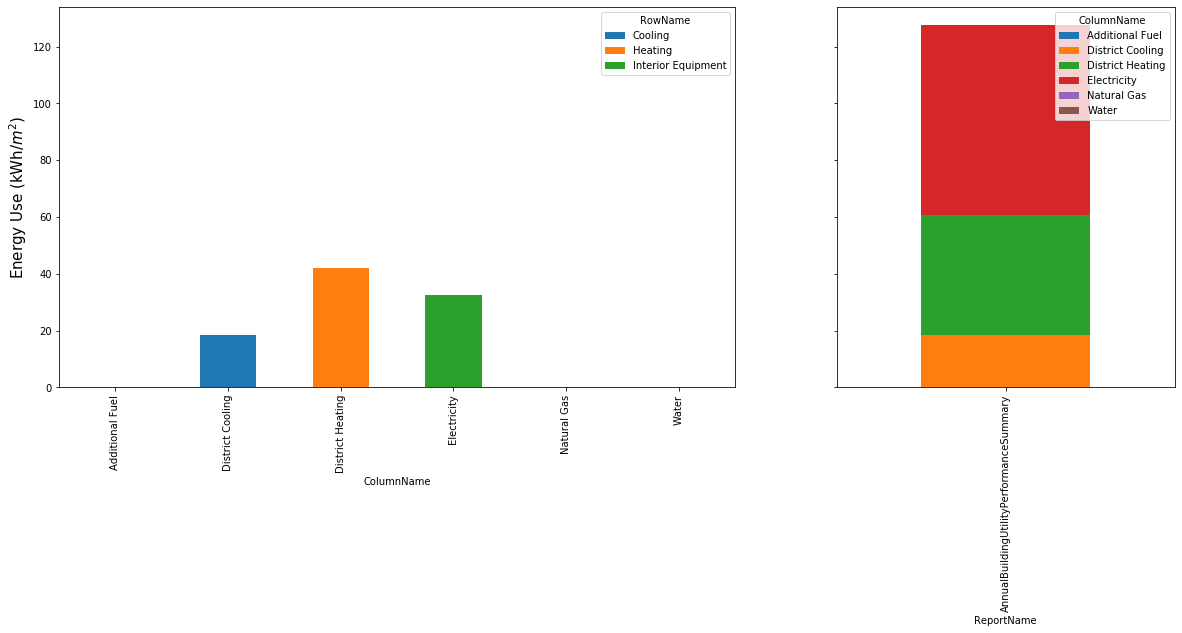

In [5]:

def plot_end_uses():
    end_uses = select_tabular_report('AnnualBuildingUtilityPerformanceSummary', 'End Uses')

    # Preprocess dataframe
    end_uses['Value'] = pd.to_numeric(end_uses['Value'])
    end_uses['Value'] = end_uses['Value'].apply(gj_to_kwh)
    floor_area = get_total_floor_area()
    end_uses['Value'] = end_uses['Value'] / floor_area
    
    end_uses = end_uses.drop(columns=['TabularDataIndex'])
    total_end_uses = end_uses[end_uses['RowName'] == 'Total End Uses']
    end_uses_only = end_uses[(end_uses['RowName'] == 'Cooling') 
                             | (end_uses['RowName'] == 'Interior Equipment') 
                             | (end_uses['RowName'] == 'Heating')]

    fig, axes = plt.subplots(1, 2, sharey=True,
                             gridspec_kw={'width_ratios': [2, 1]}, figsize=(20,7))

    axes[0].set_ylabel('Energy Use (kWh/$m^2$)', fontsize=15)

    # plot by type
    end_uses_pivot = end_uses_only.pivot(index='ColumnName', columns='RowName', values='Value')
    end_uses_pivot.plot.bar(stacked=True, ax=axes[0]);

    # plot total
    total_end_uses_pivot = total_end_uses.pivot(index='ReportName', columns='ColumnName', values='Value')
    return total_end_uses_pivot.plot.bar(stacked=True, ax=axes[1])
    
end_uses_plot = plot_end_uses()

## PLOT TIME SERIES

In [6]:
time = select_all_from_table('Time')
time.head()

,TimeIndex,Year,Month,Day,Hour,Minute,Dst,Interval,IntervalType,SimulationDays,DayType,EnvironmentPeriodIndex,WarmupFlag
0,1,2006,1,1,0,10,0.0,10,-1,1,Sunday,1,0
1,2,2006,1,1,0,20,0.0,10,-1,1,Sunday,1,0
2,3,2006,1,1,0,30,0.0,10,-1,1,Sunday,1,0
3,4,2006,1,1,0,40,0.0,10,-1,1,Sunday,1,0
4,5,2006,1,1,0,50,0.0,10,-1,1,Sunday,1,0


In [7]:
report_dict = select_all_from_table('ReportDataDictionary')
report_dict.head()

,ReportDataDictionaryIndex,IsMeter,Type,IndexGroup,TimestepType,KeyValue,Name,ReportingFrequency,ScheduleName,Units
0,7,0,Avg,Zone,HVAC System,Environment,Site Outdoor Air Drybulb Temperature,Monthly,None,C
1,9,1,Sum,Facility:Electricity,HVAC System,,Electricity:Facility,Zone Timestep,None,J
2,11,1,Sum,Facility:Electricity,HVAC System,,Electricity:Facility,Daily,None,J
3,81,0,Avg,Zone,HVAC System,OFFICE THERMAL ZONE,Zone Lights Electric Power,Zone Timestep,None,W
4,119,0,Avg,Zone,HVAC System,OFFICE THERMAL ZONE,Zone Windows Total Transmitted Solar Radiation...,Hourly,None,W


In [8]:
report = select_all_from_table('ReportData')
report.head()

,ReportDataIndex,TimeIndex,ReportDataDictionaryIndex,Value
0,1,1,81,13.320339
1,2,1,9,38992.265485
2,3,1,247,259476.347931
3,4,1,284,0.000000
4,5,2,81,13.320339


In [9]:
reporting_frequencies = ['Zone Timestep', 'Hourly', 'Daily', 'Monthly']
index_groups = ['Facility:DistrictHeating', 'Facility:Electricity', 'Zone', 'Facility:DistrictCooling']

def zero_index_minutes(row):
    minute = row['Minute']
    hour = row['Hour']
    
    minute_new = minute
    return row

def index_time_series(df, frequency):
    if frequency == 'Monthly':
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + 
            '/01'
        )
    elif frequency == 'Daily':
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str)
        )
    elif frequency == 'Hourly':
        df['Hour'] = df['Hour'] - 1
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str) + ' ' +
            df['Hour'].astype(str) + ':00'
        )
    else:
        df['Minute'] = df['Minute'] - 10
        df.loc[df.Minute < 0, 'Hour'] = df.loc[df.Minute < 0, 'Hour'] - 1
        df.loc[df.Minute < 0, 'Minute'] = 50
        
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '/' + 
            df['Month'].astype(str) + '/' + 
            df['Day'].astype(str) + ' ' +
            df['Hour'].astype(str) + ':' +
            df['Minute'].astype(str)
        )
    
    return df['Date']


def select_time_series(reporting_frequency, index_group, convert_j=True):
    q = "SELECT * FROM ReportData as RD " \
        "JOIN ReportDataDictionary as RDD on RD.ReportDataDictionaryIndex = RDD.ReportDataDictionaryIndex " \
        "JOIN Time as T on T.TimeIndex = RD.TimeIndex " \
        "AND RDD.ReportingFrequency == '{}' " \
        "AND IndexGroup == '{}' ".format(reporting_frequency, index_group)
    
    df = pd.read_sql(q, conn)
    df.index = index_time_series(df, reporting_frequency)
    
    df.Value = pd.to_numeric(df.Value)

    if convert_j:
        df.loc[df.Units == 'J', 'Value'] = df.loc[df.Units == 'J', 'Value'].apply(j_to_kwh)
        df.loc[df.Units == 'J', 'Units'] = 'kWh'
    return df


heating_time_series = select_time_series('Zone Timestep', 'Facility:DistrictHeating')
cooling_time_series = select_time_series('Zone Timestep', 'Facility:DistrictCooling')

Total Heating (kWh/m2) 42.119452482855785


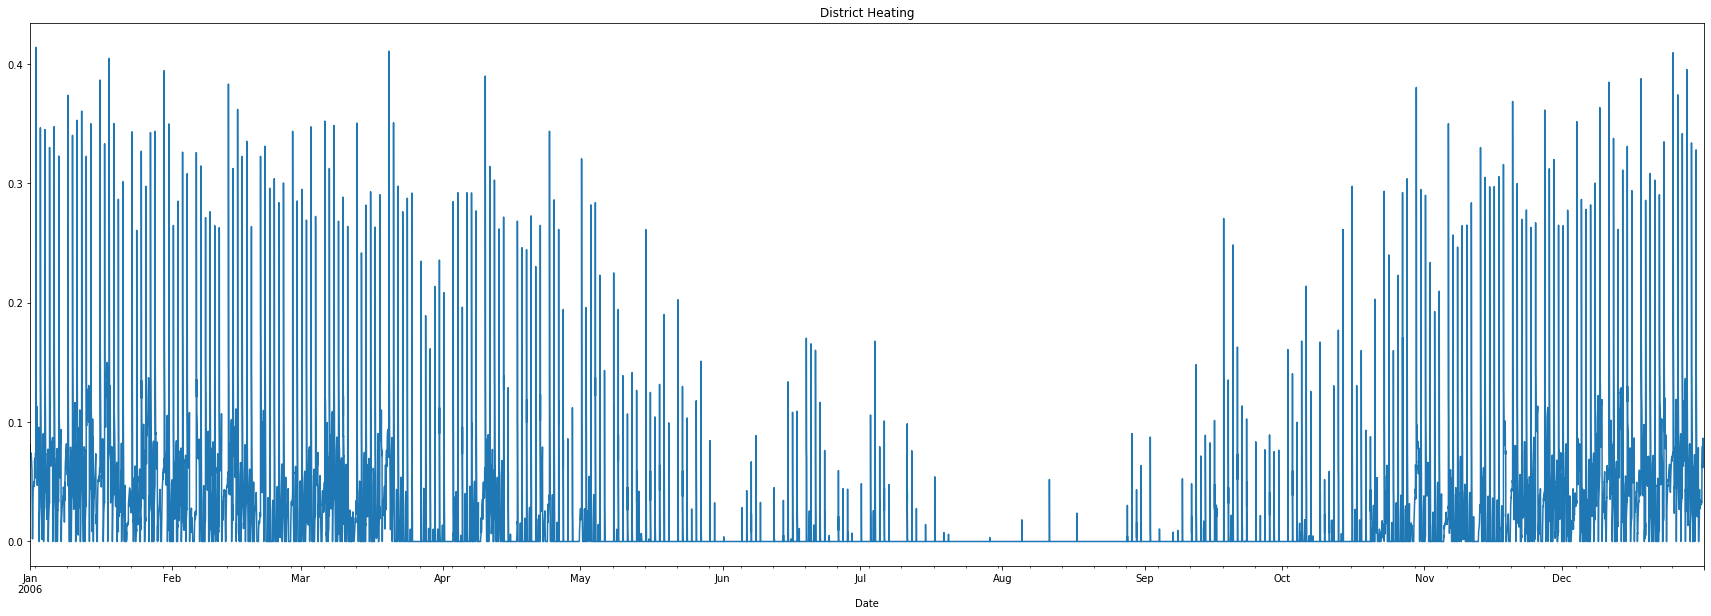

In [10]:
print('Total Heating (kWh/m2)', heating_time_series['Value'].sum() / get_total_floor_area() )
heating_time_series['Value'].plot(figsize=(30,10), title='District Heating');

Total Cooling (kWh/m2) 18.41505576222485


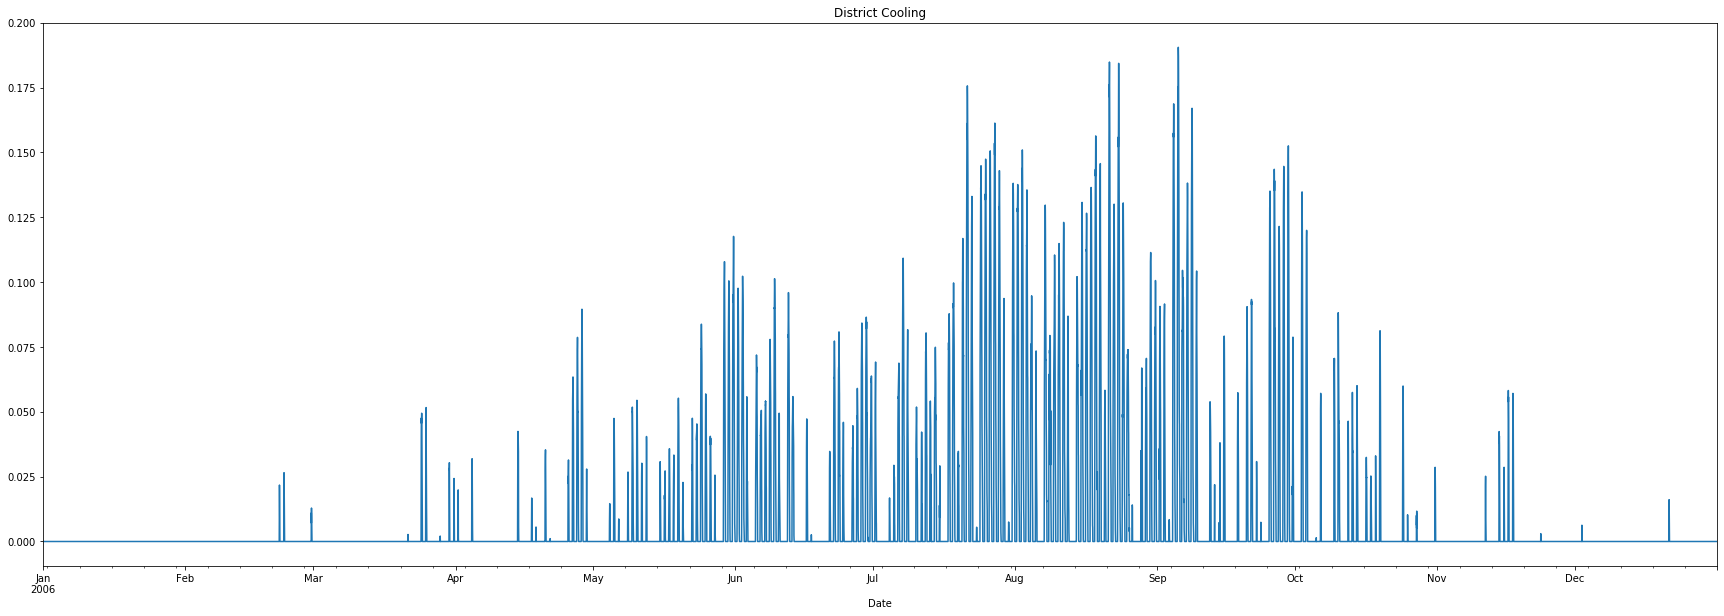

In [11]:
print('Total Cooling (kWh/m2)', cooling_time_series['Value'].sum() / get_total_floor_area())
cooling_time_series['Value'].plot(figsize=(30,10), title="District Cooling");